# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 5
&copy; 2021 Prof. Dr. Philipp Hennig & Lukas Tatzel

This sheet is **due on Monday 29 November 2021 at 10 am sharp (i.e. before the start of the lecture).**

---

In [2]:
# Make inline plots vector graphics
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Text(0.5, 1.0, 'CDF')

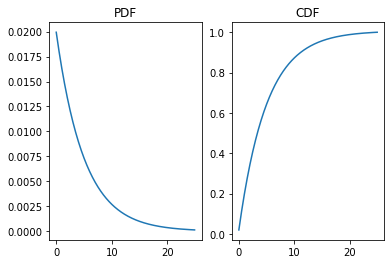

In [22]:
# Task 1
def poisson(la,max,step):
    x = np.arange(0,max,step)
    return la*np.exp(-la*x), x
la = 0.2
pdf, x = poisson(la,25,0.1)
pdf_norm = pdf/pdf.sum()
cdf = np.cumsum(pdf_norm)
# mean = x[np.where(cdf >= 0.5)][0]
# print(f"Mean: {mean}")
# var_pdf = np.var(pdf_norm)
fig, axs = plt.subplots(1,2)
axs[0].plot(x,pdf_norm)
axs[0].set_title('PDF')
axs[1].plot(x,cdf)
axs[1].set_title('CDF')

In [42]:
# Task 2
la_bus = 1/6 
pdf_bus, x_bus = poisson(la,25,1/60)
pdf_bus_norm = pdf_bus/pdf_bus.sum()
cdf_bus = np.cumsum(pdf_bus_norm)
cum_prob_20 = cdf_bus[np.where(x_bus == 20)]
expect = (pdf_bus_norm*x_bus).sum()
# a)
print(f"Expected value is: {expect} minutes")
# b)
print(f"The p-value assigned to wait 20 minutes: {(1-cum_prob_20)*100}%")
# I would use a two sided test that is calculating the p-value until the expected value with cum_prob_X
# and the p-values for x >= the expected value with 1-cum_prob_x. 
# c)
cum_prob_1sec = cdf_bus[np.where(x_bus == 1/60)]
print(f"The p-values assigned to wait 1 second: {(cum_prob_1sec)*100}%")


Expected value is: 4.822079923637833
The p-value assigned to wait 20 minutes: [1.1594867]%
The p-values assigned to wait 1 second: [0.66895677]%


# 2c)
Using a one sided test would not account for very short waiting times which should also reject the
null hypothesis. Therefore, a two sided test appears more suitable, rejecting the null hypothesis for very long and
very short waiting times.


## Hypothesis Testing & *Hunting* for Significance 

**What is this week's tutorial about?** In this week's tutorial, we will analyze data from the 1. Fußball-Bundesliga (the German premier soccer league). The goal is to investigate the effect of the Corona pandemic on the teams' performances. More precisely, we will try to find teams that achieved significantly worse results in the first "Corona-year" 2020 than in previous years (possibly caused by empty stadiums, etc.). For that purpose, we will conduct multiple hypotheses tests and discuss whether and how we should therefore adapt our strategy. 

### 1. Load and prepare the Data

In this tutorial, we will use data provided by [OpenLigaDB](https://www.openligadb.de/). The function `get_league_table` allows you to retrieve the data via the API interface and convert it into a Pandas data frame.

In [ ]:
import requests

API_ENDPOINT = "https://www.openligadb.de/api"

def get_league_table(league, year):
    """
    Get team rankings as Pandas data frame.
    
    Parameters
    ----------
    league : str
        'bl1' for 1. Bundesliga, see https://github.com/OpenLigaDB/OpenLigaDB-Samples
    year : int
        Get data for this year
    """
    response = requests.get(f"{API_ENDPOINT}/getbltable/{league}/{year}")
    data = response.json()
    return pd.DataFrame(data)

# Get and display data for the 1. Bundesliga ('bl1') for 2020
data = get_league_table(league="bl1", year=2020)
display(data.head())

**Task:** Your first task is to essentially recreate the following table:

<br />

<div>
<img src="Table.PNG" width="750"/>
</div>

**Recommended Steps:**
1. First, gather data for all years from 2010 to 2020 and store this data into a single Pandas data frame. Each time you receive a data frame from `get_league_table`, extract the relevant columns and add the corresponding year as a new column `"year"`.
2. Split this data frame into two separate data frames: One for the year 2020, the other one for the accumulated results from 2010 to 2019. 
3. Merge the two data frames on the `"TeamName"`-column. Make sure that you only include teams that played in 2020 and also in at least one other season in the past. 

In [ ]:
# TODO

### 2. Compute p-Values

Our goal is to find out if there are teams that achieved significantly worse results in 2020 than in previous years. In the lecture, you already learned about a statistical test for this purpose: 

- First, we put a beta-prior on $f_0$ (the winning probability before 2020) which is based on $m_0$ (the number of wins before 2020) in $n_0$ matches (the number of matches before 2020).

- Under the null hypothesis $H_0: f_1 = f_0$, the number of wins in 2020 $m_1$ (given the number of matches in 2020 $n_1$) follows a binomial distribution. 

- Putting these building blocks together, we obtain a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution)

    \begin{equation}
    p(m_1 \vert n_1, m_0, n_0) 
    = {n_1\choose m_1} 
    \frac{\mathcal{B}(m_0 + m_1 + 1, (n_0-m_0) + (n_1-m_1) + 1)}
    {\mathcal{B}(m_0 + 1, n_0 - m_0 + 1)}.
    \end{equation}

    This tells us the probability to observe $m_1$ wins in 2020, given the number of matches in 2020 $n_1$ and the statistics $m_0$, $n_0$ for the years before. 

**Task:** Plot $p(m_1 \vert n_1, m_0, n_0)$ for $m_1 \in \{0, 1, ..., n_1\}$ for some arbitrary numbers $n_1$, $m_0$ and $n_0$. Play around with these parameters to gain some intuition how this distribution behaves. 

In [ ]:
from scipy.stats import betabinom

# TODO

- The $p$-value represents the probability to observe a certain number of wins or *more extreme* results. Let's assume, the team we consider has won $3$ times in 2020. Since we are interested in teams that have played particularly badly, we sum $p(m_1 \vert n_1, m_0, n_0)$ over $m_1 = 0, 1, 2, 3$. Evaluating the cumulative distribution function `betabinom.cdf` performs this summation for us. 

- If this probability is small, then it is very unlikely that the observed data has been generated from the winning probability $f_0$. Or, in other words, the team has played particularly badly in 2020. We thus reject $H_0$ if $p \leq \alpha := 5 \%$. 

**Task:** Compute the $p$-values for every team and add the results as a new column `"p-value (won)"`. Check if there are teams whose $p$-value falls below the $5 \%$ threshold. 

In [ ]:
def p_val_won(m_1, n_1, m_0, n_0):
    """
    Compute p-value by summing the evidence p(m_1 | n_1, m_0, n_0) over the 
    observed number of wins and 'more extreme' (i.e. smaller) results.
    
    Parameters
    ----------
    m_1 : int
        Number of wins in 2020 (0 <= m_1 <= n_1)
    n_1 : int
        Number of matches in 2020 (n_1 > 0)
    m_0 : int
        Number of wins before 2020 (0 <= m_0 <= n_0)
    n_0 : int
        Number of matches before 2020 (n_0 > 0)
    """
    return betabinom.cdf(m_1, n_1, m_0 + 1, n_0 - m_0 + 1)

In [ ]:
# TODO

Our goal is to find teams that played significantly worse in 2020 compared to previous years. We did this by checking whether the number of games won this year is "surprisingly" low. Now, we will use an alternative approach: We check whether the number of games *lost* this year is particularly *high*. For this, we can re-use the statistical beta-binomial model from above by simply plugging in the number of *lost* games for $m_0$ and $m_1$. 

**Task:** Compute the corresponding $p$-values and store the results in a new column `"p-value (lost)"`. Note that you cannot simply use the `p_val_won` function from above. This time, the question is: What is the probability for observing $m_1$ or *more* lost matches.

In [ ]:
def p_val_lost(m_1, n_1, m_0, n_0):
    """
    Compute p-value by summing the evidence p(m_1 | n_1, m_0, n_0) over the 
    observed number of lost matches and 'more extreme' (i.e. larger) results.
    
    Parameters
    ----------
    m_1 : int
        Number of lost matches in 2020 (0 <= m_1 <= n_1)
    n_1 : int
        Number of matches in 2020 (n_1 > 0)
    m_0 : int
        Number of lost matches before 2020 (0 <= m_0 <= n_0)
    n_0 : int
        Number of matches before 2020 (n_0 > 0)
    """
    raise NotImplementedError

In [ ]:
# TODO

### 3. Bonferroni Correction

By now, we conducted $2 \cdot 17 = 34$ hypotheses tests at the significance level $\alpha = 5 \%$. $\alpha$ corresponds to the probability of a type I error, i.e. rejecting the null hypothesis given that it is true. However, the more tests we perform, the higher the chance of observing a rare event simply due to chance. For example, if we assume that $H_0$ holds for every team, the chance of falsely rejecting at least one out of $34$ hypothesis is $1 - (1-0.05)^{34} \approx 83 \%$ (assuming independent tests). Thus, it is quite likely that one of the results we found is a type I error. The Bonferroni correction is one possibility for compensating for that effect by decreasing the significance level. The significance level is defined as the original one divided by the total number of hypotheses. 

**Task:** Define the new significance level and see whether you can (still) find significant results. 

In [ ]:
# TODO

The Bonferroni method tends to be too *conservative*, i.e. the significance level might be too restrictive. This is especially the case when the tests are dependent. 

**Task:** Think about if the tests we performed are dependent or independent and give a short explanation.

**Solution:** TODO

### 4. Q-Q-Plots

We conducted multiple hypothesis tests at significance level $\alpha = 5 \%$. $\alpha$ corresponds to the probability of a type I error, i.e. $\alpha = P(\text{type 1 error}) = P(p \leq \alpha\,|\,H_0\,\text{ is true}) = \text{cdf}_p(\alpha)$. So, under $H_0$, the cumulative distribution function of the $p$-value at $\alpha$ is $\text{cdf}_p(\alpha) = \alpha$. That implies that $p$ is uniformly distributed under $H_0$. Let us visually explore, if the observed $p$-values are likely to be drawn from a uniform distribution. This can be done by a so-called Q-Q plot. 

The idea of a Q-Q Plot is to compare the empirical quantiles of the empirical distribution of the $p$-values with the quantiles of the theoretical distribution (the uniform distribution, as explained above). Let $\beta \in (0, 1)$. 
- The theoretical $\beta$-quantile of the uniform distribution is $q_{\beta} = \beta$.
- The empirical $\beta$-quantile of the *ascendingly ordered* sample $(p_1, ..., p_n)$ is $q_{\beta} = p_{\lfloor n\cdot\beta + 1\rfloor}$

**Task:** Complement the two functions below such that they return the quantiles defined above. Do not use `numpy.quantile` or similar.  Generate a vector that discretizes the variable $\beta$ and compute the corresponding quantiles. Plot the theoretical quantiles over the empirical quantiles. If the distributions are *similar*, the points will lie on the $45°$ line $y = x$. The result should look like this: 

<br />

<div>
<img src="Plot.PNG" width="350"/>
</div>

In [ ]:
from math import floor

def q_theoretical(beta):
    """
    Compute theoretical beta-quantile of uniform distribution.

    Parameters
    ----------
    beta : array-like, shape=(n,)
    """
    raise NotImplementedError

def q_empirical(beta, p):
    """
    Compute empirical beta-quantile of sample p.

    Parameters
    ----------
    beta : array-like, shape=(n,)
    p : array-like, shape=(n,)
        Unordered sample
    """
    raise NotImplementedError

In [ ]:
# TODO

Of course, the two generated lines do not coincide perfectly with the $45°$ line $y = x$. That raises the question, what deviation from that line we would expect if the $p$-values were actually drawn from a uniform distribution. One way to approach this question visually is to generate multiple samples of a uniform distribution (each sample consisting of $17$ numbers, like `p-values (won)` and `p-values (lost)`) and make a Q-Q Plot for each sample. So, we basically sample Q-Q plots under $H_0$. 

**Task:** Generate multiple (e.g. $1000$) samples as described above and show the corresponding Q-Q Plots together with the two lines from the previous task. 

In [ ]:
# TODO